In [1]:
import numpy as np
import pandas as pd

#### Symbols

In [2]:
symbols = pd.read_pickle('../datasets/data.pickle', compression='infer')
symbols = pd.DataFrame(symbols)

In [3]:
X_symbols = symbols["img"].apply(lambda x: np.reshape(x, (1, 28, 28)))

In [4]:
y_symbols = symbols["label"]
y_symbols

0       +
1       -
2       x
3       /
4       (
       ..
4895    x
4896    /
4897    (
4898    )
4899    ,
Name: label, Length: 4900, dtype: object

In [5]:
def symbol_to_number(x):
    if x == '+':
        return 10
    if x == '-':
        return 11
    if x == 'x':
        return 12
    if x == '/':
        return 13
    if x == '(':
        return 14
    if x == ')':
        return 15
    if x == ',':
        return 16

In [6]:
y_symbols = y_symbols.apply(symbol_to_number)
y_symbols

0       10
1       11
2       12
3       13
4       14
        ..
4895    12
4896    13
4897    14
4898    15
4899    16
Name: label, Length: 4900, dtype: int64

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def plot_figure(X, y, idx):
    plt.imshow(X[idx][0], cmap='Greys',  interpolation='nearest')
    plt.title(y[idx])
    plt.show()

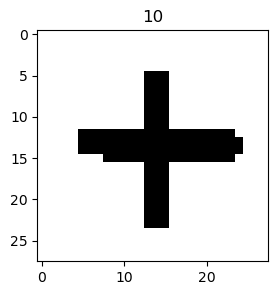

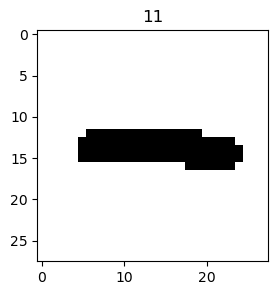

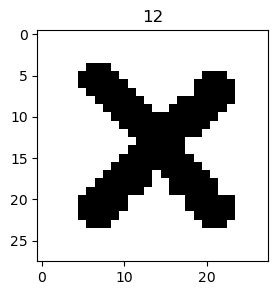

In [9]:
plt.rcParams["figure.figsize"] = (20,3)

for i in range(0,3):
    plot_figure(X_symbols, y_symbols, i)

#### Digits

In [10]:
train = pd.read_csv('../datasets/train.csv') # Only using train.csv, as test.csv has no targets (y)

In [11]:
X_numbers = train.drop('label',axis=1).apply(lambda x: np.array(x).reshape(1,28,28), axis=1)

In [12]:
y_numbers = train["label"]
y_numbers

0        0
1        1
2        2
3        3
4        4
        ..
59995    5
59996    6
59997    7
59998    8
59999    9
Name: label, Length: 60000, dtype: int64

In [13]:
X_numbers = X_numbers/255
X_numbers = X_numbers.apply(lambda x: np.ceil(x))

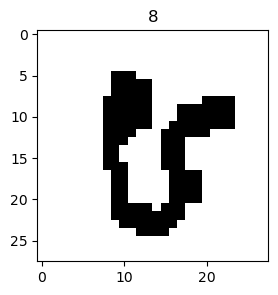

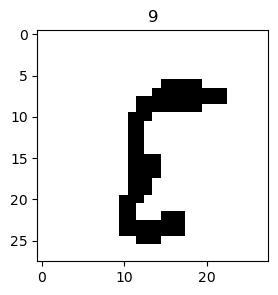

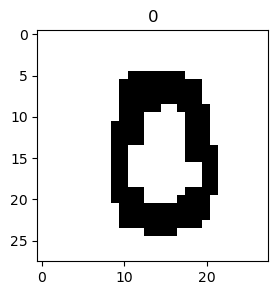

In [14]:
for i in range(18,21):
    plot_figure(X_numbers, y_numbers, i)

#### Transforming and augmenting symbols dataset

In [15]:
num_n = len(X_numbers) / 10
num_s = len(X_symbols) / 7

print(num_n / num_s)

8.571428571428571


##### There are about 8.57 times more images of a number than of a symbol
##### Applying transformations, to match handwritten numbers and augmenting symbols dataset 9 times, to match the quantity.

In [16]:
import torch
import torchvision.transforms.v2 as v2 

In [17]:
transforms = v2.Compose([
    v2.CenterCrop(28),
    v2.RandomRotation(degrees=15),
    v2.RandomAffine(degrees=0, translate=(0.1,0.1))
])

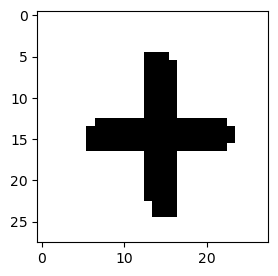

In [18]:
sample = torch.Tensor(X_symbols[7])
plt.imshow(sample[0], cmap='Greys',  interpolation='nearest')
plt.show()

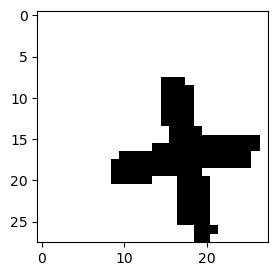

torch.Size

In [19]:
transformed_sample = transforms(sample)
plt.imshow(transformed_sample[0], cmap='Greys',  interpolation='nearest')
plt.show()
type(transformed_sample.shape)

In [20]:
def tensor_transform(x):
    x = torch.Tensor(x)
    x = transforms(x)
    return x.clone().detach()

In [21]:
augmentation_factor = 10

new_X_symbols = []
new_y_symbols = []

for i in range(augmentation_factor):
    new_X_symbols.extend(X_symbols.apply(tensor_transform).values)
    new_y_symbols.extend(y_symbols.apply(torch.tensor).values)
    print(f"Augmentation {i+1} / {augmentation_factor}")

Augmentation 1 / 10
Augmentation 2 / 10
Augmentation 3 / 10
Augmentation 4 / 10
Augmentation 5 / 10
Augmentation 6 / 10
Augmentation 7 / 10
Augmentation 8 / 10
Augmentation 9 / 10
Augmentation 10 / 10


In [22]:
X_symbols = torch.stack(new_X_symbols)
y_symbols = torch.tensor(new_y_symbols)

In [23]:
X_numbers = torch.stack(X_numbers.apply(torch.Tensor).tolist())
y_numbers = torch.tensor(y_numbers)

In [24]:
X = torch.cat([X_numbers, X_symbols])
y = torch.cat([y_numbers, y_symbols])

In [25]:
X.shape

torch.Size([109000, 1, 28, 28])

In [26]:
y.shape

torch.Size([109000])

#### Train Test Split

In [27]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [28]:
dataset = TensorDataset(X, y)

In [29]:
train_size = int(0.67 * len(dataset))
test_size = len(dataset) - train_size

In [30]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

#### Convolutional Neural Network 

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

In [34]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32, momentum=0.15)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.15)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(32, momentum=0.15)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 3 * 3, 256)
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 17)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        logits = self.fc2(x)
        return logits

In [35]:
model = ConvNet().to(device)
print("Device:", device, "\n")
print(model)

Device: cpu 

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.15, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.15, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.15, affine=True, track_runn

In [36]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([32, 32, 5, 5])
conv2.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
conv4.weight 	 torch.Size([64, 64, 3, 3])
conv4.bias 	 torch.Size([64])
bn2.weight 	 torch.Size([64])
bn2.bias 	 torch.Size([64])
bn2.running_mean 	 torch.Size([64])
bn2.running_var 	 torch.Size([64])
bn2.num_batches_tracked 	 torch.Size([])
conv5.weight 	 torch.Size([32, 64, 5, 5])
conv5.bias 	 torch.Size([32])
conv6.weight 	 torch.Size([32, 32, 5, 5])
conv6.bias 	 torch.Size([32])
bn3.weight 	 torch.Size([32])
bn3.bias 	 torch.Size([32])
bn3.running_mean 	 torch.Size([32])
bn3.running_var 	 torch.Size([32])
bn3.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([256, 288])
fc1

#### Optimizer and loss function

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-3,
)

print(loss_fn)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [38]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]}]


#### Training loop

In [39]:
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [40]:
def train(dataloader, model, loss_fn, optimizer):
    size = 0
    model.train()
    
    batch_loss = {}
    batch_accuracy = {}
    
    correct = 0
    _correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)
        
        correct += _correct
        
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size
        
        size += _batch_size
        
    correct /= size
    print(f"Training: \n Accuracy: {(100*correct):>0.2f}%")
    
    return batch_loss , batch_accuracy

#### Testing loop

In [41]:
def test(dataloader, model, loss_fn):
    size = 0
    num_batches = len(dataloader)
    
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = {}
    batch_accuracy = {}
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)
            
            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size
            
    correct /= size
    test_loss /= num_batches
    print(f"Testing: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
     
    return batch_loss , batch_accuracy

#### Training and Testing

In [42]:
train_batch_loss = []
train_batch_accuracy = []
test_batch_accuracy = []
test_batch_loss = []
train_epoch_no = []
test_epoch_no = []

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}")
    _train_batch_loss, _train_batch_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    _test_batch_loss, _test_batch_accuracy = test(test_dataloader, model, loss_fn)
    
    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))     
    
    for i in range(len(_test_batch_loss)):
        test_batch_loss.append(_test_batch_loss[i])
        test_batch_accuracy.append(_test_batch_accuracy[i])
        test_epoch_no.append( t + float((i+1)/len(_test_batch_loss)))     

print("\nFinished")

Epoch 1
Training: 
 Accuracy: 96.29%
Testing: 
 Accuracy: 98.62%, Avg loss: 0.049032 

Epoch 2
Training: 
 Accuracy: 98.90%
Testing: 
 Accuracy: 98.93%, Avg loss: 0.037344 

Epoch 3
Training: 
 Accuracy: 99.12%
Testing: 
 Accuracy: 99.39%, Avg loss: 0.022025 

Epoch 4
Training: 
 Accuracy: 99.21%
Testing: 
 Accuracy: 99.41%, Avg loss: 0.021423 

Epoch 5
Training: 
 Accuracy: 99.37%
Testing: 
 Accuracy: 99.42%, Avg loss: 0.023173 

Epoch 6
Training: 
 Accuracy: 99.43%
Testing: 
 Accuracy: 99.59%, Avg loss: 0.015661 

Epoch 7
Training: 
 Accuracy: 99.49%
Testing: 
 Accuracy: 99.56%, Avg loss: 0.017469 

Epoch 8
Training: 
 Accuracy: 99.55%
Testing: 
 Accuracy: 99.60%, Avg loss: 0.017322 

Epoch 9
Training: 
 Accuracy: 99.53%
Testing: 
 Accuracy: 99.62%, Avg loss: 0.015708 

Epoch 10
Training: 
 Accuracy: 99.60%
Testing: 
 Accuracy: 99.58%, Avg loss: 0.018041 

Epoch 11
Training: 
 Accuracy: 99.60%
Testing: 
 Accuracy: 99.59%, Avg loss: 0.018316 

Epoch 12
Training: 
 Accuracy: 99.67%
Tes

#### Saving the model

In [45]:
model_path = "../model/ConvNet.pt"

In [46]:
torch.save(model.state_dict(), model_path)